# Exploratory Data Analysis

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Description of the Data

Our source data is

### Data Cleaning Process

[Description of the process of building the whole dataset]

For the exploratory data analysis and baseline model, we decided to further filter the data to a random sample of 100 playlists for a training set and 100 playlists for a test set.

### Data Structure

In [27]:
# Import the dataframe
complete_df = pd.read_csv("data/playlists.csv", index_col = 0)
combined_df = pd.read_csv("data/subset100playlists.csv", index_col = 0)

51748

In [3]:
combined_df.dtypes

index                 int64
pid                   int64
pos                   int64
track_uri            object
artist_uri_x         object
track_name           object
artist_name          object
artist_uri_y         object
album_name           object
album_uri            object
count                 int64
acousticness        float64
analysis_url         object
danceability        float64
duration_ms           int64
energy              float64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
track_href           object
type                 object
valence             float64
dtype: object

## Exploratory Data Analysis

In [ ]:
n_tracks = complete_df.track_uri.nunique()
n_playlists = complete_df.pid.nunique()

summary_stats = pd.DataFrame([{'Statistic': 'Number of Unique Tracks', 'Value': n_tracks},
                              {'Statistic': 'Number of Unique Playlists', 'Value': n_playlists}])

In [134]:
track_uri_stats = complete_df.groupby('track_uri')['pid'].count().sort_values(ascending = False).cumsum()
weights = 1/track_uri_stats.max()
weighted_track_uri_stats = track_uri_stats * weights
cum_px = weighted_track_uri_stats[weighted_track_uri_stats.gt(0.9)].index[0]
cum_px = round(weighted_track_uri_stats.index.get_loc(cum_px)/n_tracks, 2)*100

In [135]:
pid_stats = complete_df.groupby('pid')['track_uri'].count()

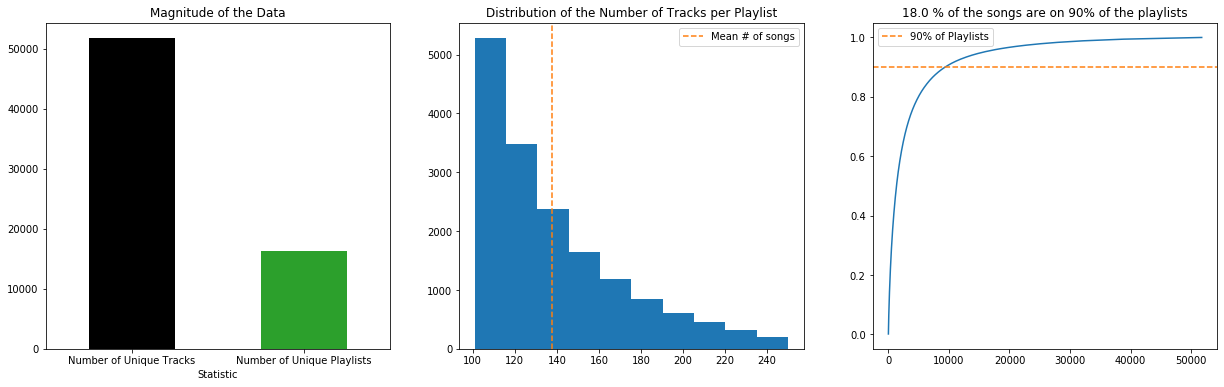

In [143]:
fig, ax = plt.subplots(1,3, figsize = (21,6))

ax[0].set_title('Magnitude of the Data')
summary_stats.plot.bar(x = 'Statistic', y='Value', rot=0, color = ['k','C02'], legend = False, ax = ax[0])

ax[1].set_title('Distribution of the Number of Tracks per Playlist')
ax[1].hist(pid_stats)
ax[1].axvline(pid_stats.mean(), ls = '--', color = 'C01', label = 'Mean # of songs')
ax[1].legend()

ax[2].set_title(f'{cum_px} % of the songs are on 90% of the playlists')
ax[2].plot(np.arange(n_tracks), weighted_track_uri_stats)
ax[2].axhline(0.9, ls = '--', color = 'C01', label = '90% of Playlists')
ax[2].legend()
plt.show()

The plots above show immediately the impact of our playlist selection criteria on the dataset that will be used for training, testing, and validating our models.
* The number of songs per playlist is not normally distributed, and we only have playlists that include more than 100 songs.
* 18% of songs are on 90% of playlists. So we can expect overlap of songs between playlists.

In [154]:
def process_playlists(df, fun):
    index = df.pid.unique
    rows = complete_df.pid.nunique()
    columns = df.shape[1]
    output = pd.DataFrame(np.zeros((rows, columns)))
    output.set_index(index)
    for playlist in index:
        subset = df.loc[df['pid'] == playlist]
        output[playlist] = fun(subset)

def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [155]:
process_playlists(combined_df, gini)

TypeError: unique() takes 1 positional argument but 2 were given

In [148]:
np.zeros((1, 2))

array([[0., 0.]])